# Mask R-CNN - Train on Honeycomb Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [2]:
# Execute environment dependent setup
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  # Link to the WrightBeeLab shared GoogleDrive. 
  # Follow the authorization instructions, choosing [user]@wrightbeelab.org:
  from google.colab import drive
  drive.mount('/content/drive')

  # Install all appropriate dependencies
  %cd '/content/drive/My Drive/GitHub/Mask_RCNN/'
  %pip install -r requirements.txt
  !python3 setup.py install
  %pip install icecream
  %cd '/content/drive/My Drive/GitHub/Mask_RCNN/honeycomb/'
else:
  print('Not running on CoLab')
  %pip install -r requirements.txt
  !python3 setup.py install
  %pip install icecream

Running on CoLab
Mounted at /content/drive
/content/drive/My Drive/GitHub/Mask_RCNN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.9/83.9 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 10.8 MB/s eta 0:00:00
/usr/local/lib/python3.9/dist-packages/setuptools/dist.py:697: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/setuptools/dist.py:697: UserWarning: Usage of dash-separat

In [3]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from icecream import ic

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
ic(ROOT_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import honeycomb

# Comment out to avoid reloading imported modules if they change
%load_ext autoreload
%autoreload 2

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "honeycomb/honeycomb_dataset")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

ic| ROOT_DIR: '/content/drive/MyDrive/GitHub/Mask_RCNN'


In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Training as per command line but Jupyter

In [49]:
weights = "last"  # replace with "last" if rerunning; or "coco" to start

# Configurations
config = honeycomb.HoneycombConfig()
ic(Config.STEPS_PER_EPOCH)
ic(config.STEPS_PER_EPOCH)
#config.display()

# Create model
model = modellib.MaskRCNN(mode="training", config=config, model_dir=honeycomb.DEFAULT_LOGS_DIR)

# Select weights file to load
if weights == "coco":
    weights_path = honeycomb.COCO_WEIGHTS_PATH
    # Download weights file
    if not os.path.exists(weights_path):
        utils.download_trained_weights(weights_path)
elif weights == "last":
    # Find last trained weights
    weights_path = model.find_last()
elif weights == "imagenet":
    # Start from ImageNet trained weights
    weights_path = model.get_imagenet_weights()

# Load weights
ic("Loading weights ", weights_path)
if weights == "coco":
    # Exclude the last layers because they require a matching
    # number of classes
    model.load_weights(weights_path, by_name=True, exclude=[
        "mrcnn_class_logits", "mrcnn_bbox_fc",
        "mrcnn_bbox", "mrcnn_mask"])
else:
    model.load_weights(weights_path, by_name=True)

ic(model, DATASET_DIR)

honeycomb.train(model, DATASET_DIR, "train")


ic| Config.STEPS_PER_EPOCH: 1000
ic| config.STEPS_PER_EPOCH: 7
ic| "Loading weights ": 'Loading weights '
    weights_path: '/content/drive/MyDrive/GitHub/Mask_RCNN/logs/honeycomb20230311T2012/mask_rcnn_honeycomb_0040.h5'


Re-starting from epoch 40


ic| model: <mrcnn.model.MaskRCNN object at 0x7fd340e60700>
    DATASET_DIR: '/content/drive/MyDrive/GitHub/Mask_RCNN/honeycomb/honeycomb_dataset'
ic| len(polygons): 106, len(class_ids): 106
ic| len(polygons): 91, len(class_ids): 91
ic| len(polygons): 90, len(class_ids): 90
ic| len(polygons): 54, len(class_ids): 54
ic| len(polygons): 82, len(class_ids): 82
ic| len(polygons): 32, len(class_ids): 32
ic| len(polygons): 51, len(class_ids): 51
ic| len(polygons): 96, len(class_ids): 96
ic| 'Train network heads', Config.LEARNING_RATE: 0.001



Starting at epoch 40. LR=0.001

Checkpoint Path: /content/drive/MyDrive/GitHub/Mask_RCNN/logs/honeycomb20230311T2012/mask_rcnn_honeycomb_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistribut

## Detection

In [5]:
class InferenceConfig(honeycomb.HoneycombConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use fn_output_signature instead


Loading weights from  /content/drive/MyDrive/GitHub/Mask_RCNN/logs/honeycomb20230311T2012/mask_rcnn_honeycomb_0040.h5
Re-starting from epoch 40


ic| len(polygons): 96, len(class_ids): 96


original_image           shape: (512, 512, 3)         min:    7.00000  max:  228.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max:  864.00000  float64
gt_class_id              shape: (3,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (3, 4)                min:    0.00000  max:  239.00000  int32
gt_mask                  shape: (56, 56, 3)           min:    0.00000  max:    1.00000  bool


ValueError: ignored

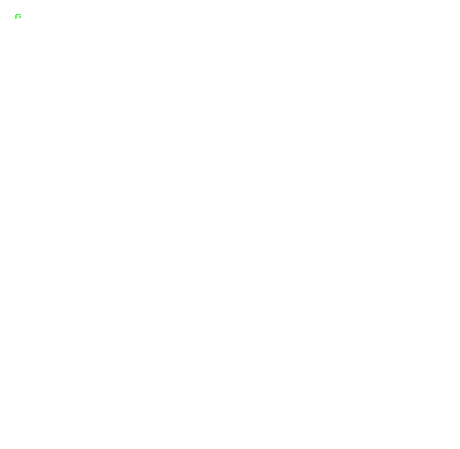

In [6]:
# Test on a random image
dataset_val = honeycomb.HoneycombDataset()
dataset_val.load_honeycomb(DATASET_DIR, "val")
dataset_val.prepare()
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8), show_mask=True)
visualize.display_images([original_image], titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None)

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  198.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -45.22000  max:  148.47000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


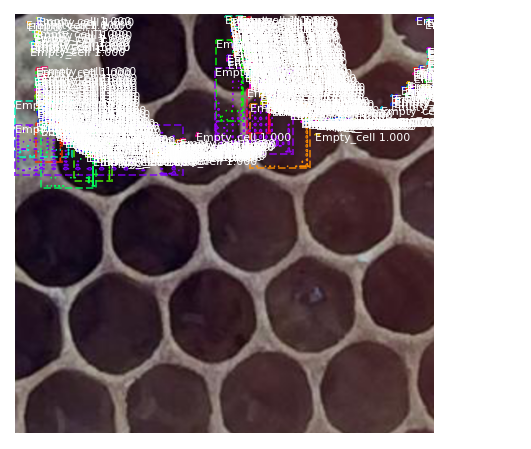

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 1)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.0
